# RAILS — Überwachtes CNN-Training für Schienenuntergrund-Klassifikation

**Ziel:** Training und Evaluation eines überwachten CNN (Transfer Learning mit ResNet50V2) zur präzisen Klassifikation von Eisenbahn-Gleisbettbildern. Aufbauend auf der unüberwachten Clustering-Analyse implementiert dieses Notebook eine **vollständige, eigenständige ML-Pipeline**:

1. **Daten-I/O** aus TFRecord-Format (Parsing, Dekodierung, Normalisierung)
2. **Modelldefinition** (vortrainiertes ResNet50V2-Backbone + leichter Klassifikationskopf)
3. **Training** mit der _besten Konfiguration_ (siehe unten)
4. **Evaluation** mit detaillierten Metriken (Confusion Matrix, klassenweise Precision/Recall/F1, Macro/Weighted Scores)
5. **Visualisierung** (Trainingskurven, Confusion Matrix, klassenweise Balkendiagramme, Klassenverteilung)
6. **Artefakte** (gespeichertes Modell + CSV/JSON-Ergebnisse)

Das Notebook basiert auf den Erkenntnissen der vorhergehenden Clustering-Phase und nutzt die beste, durch systematische Hyperparameter-Optimierung ermittelte Konfiguration für das finale Training.

## Schnellstart & Konfiguration

**Was:**  
- Setzt die Pfade zu den **TFRecord**-Dateien für Training und Evaluation.  
- Definiert **Ausgabeverzeichnis** und **Modellnamen** für Trainingsartefakte.  
- Legt **Klassenliste** und **Bildabmessungen** (224×224×3) fest, passend zum verwendeten Backbone.  
- Bündelt die feste **Best-Configuration** (Lernrate, Batchgröße, Epochen, Val-Anteil, Early-Stopping-Patience).

**Warum:**  
- Zentrale Konfiguration ermöglicht **reproduzierbare** Läufe ohne Parameter-Sweeps.  
- TFRecords als einheitliches Eingabeformat erleichtern **schnelles Laden** via `tf.data`.  
- Feste Hyperparameter sichern **Vergleichbarkeit** und verhindern „Experiment Creep“.  
- Ein Val-Anteil und Early Stopping unterstützen **stabiles Trainieren** und vermeiden Über-/Unteranpassung.


In [1]:
# TFRecord inputs 
# possible datasets: MultiLabel_TB_small_08-25.tfrecord, MultiLabel_TB_medium_08-25.tfrecord, MultiLabel_TB_large_08-25.tfrecord)
TRAIN_TFRECORD_PATH = "/media/andi/ssd2/dev/code/Overseer2/data/inputs/MultiLabel_TB_large_08-25.tfrecord"
EVAL_TFRECORD_PATH  = "/media/andi/ssd2/dev/code/Overseer2/data/inputs/MultiLabel_TB_Evaluation_08-25.tfrecord"

# Output directory + model name
OUTPUT_DIR = "./outputs_trackbed"
# possible arichtectures in ./architectures
MODEL_NAME = "PT_MultiClassResNet50_Trackbed"

# Label mapping and image shape (matches our ResNet50V2 setup)
CLASSES = ["ASPHALT", "BALLAST", "GRAS", "STONE", "ERROR"]
NUM_CLASSES = len(CLASSES)
IMG_HEIGHT = 224
IMG_WIDTH  = 224
IMG_DEPTH  = 3

# stardard training configuration (used for all trainings)
BEST_CONFIG = {
    "learning_rate": 1e-4,
    "batch_size": 32,
    "num_epochs": 30,
    "val_fraction": 0.2,         # reserve a small fraction of TRAIN for validation
    "early_stopping_patience": 5 # be gentle to avoid over/under-fitting
}


## 1. Setup: Umgebung & Reproduzierbarkeit

**Was:**
- Initialisierung von TensorFlow und Import der erforderlichen Bibliotheken
- Setzen von Seeds für Determinismus (soweit auf GPU praktikabel)
- Aktivierung des GPU-Memory-Growth zur Vermeidung von OOM-Fehlern

**Warum:**
- **Reproduzierbarkeit:** Konsistente Ergebnisse über mehrere Trainingsläufe hinweg
- **GPU-Optimierung:** Effiziente Speichernutzung verhindert Speicherüberläufe
- **Zentralisierte Konfiguration:** Alle Seeds und Umgebungseinstellungen an einem Ort

**Outputs:**
- Konfigurierte TensorFlow-Umgebung mit aktiviertem Memory-Growth
- Erstellung des Output-Verzeichnisses für Modell-Artefakte
- Ausgabe der TensorFlow-Version und des absoluten Output-Pfads

In [2]:
import os, json, random, math, itertools
from pathlib import Path
from datetime import datetime

import numpy as np
import tensorflow as tf

# Reproducibility (best-effort on GPU)
SEED = 123
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# GPU memory growth (optional but recommended)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except Exception as e:
        print(f"Could not set memory growth: {e}")

# Create output dir
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("TF version:", tf.__version__)
print("Output dir:", os.path.abspath(OUTPUT_DIR))


2025-09-07 15:30:27.291229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-07 15:30:27.370952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-07 15:30:27.391148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-07 15:30:27.493806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-07 15:30:28.763974: W tensorflow/compiler/tf2

Enabled memory growth for 1 GPU(s).
TF version: 2.17.1
Output dir: /media/andi/ssd2/dev/code/RAILS/outputs_trackbed


I0000 00:00:1757251831.288683    6258 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1757251831.425796    6258 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1757251831.431189    6258 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## 2. Daten-Pipeline: TFRecord → `tf.data.Dataset`

**Was:**
- Implementierung der Daten-Pipeline mit dem Schema aus `create_trackbed_tfrecord.ipynb`
- Mehrstufige Verarbeitung: Parsing, Dekodierung, Normalisierung und Batching

**Verarbeitungsschritte:**

1. **Feature-Parsing** aus jedem TFRecord-Beispiel
2. **Dekodierung** Raw Bytes → Bildtensor; Sicherstellung 3 Kanäle; **Resize auf 224×224**
3. **One-Hot-Encoding** der Labels (5 Klassen)
4. **Normalisierung** auf `[0,1]`-Bereich
5. **Shuffle + Split** von `TRAIN` in **Train/Validation** (nach `val_fraction`)
   Der `EVAL` TFRecord wird unverändert für die finale Evaluation geladen

**Warum:**
- **Konsistenz:** Identisches Schema wie bei der TFRecord-Erstellung gewährleistet fehlerfreie Datenverarbeitung
- **Effizienz:** `tf.data.AUTOTUNE` und Prefetching optimieren die Datenlade-Performance
- **Flexibilität:** Separate Funktionen für Training (mit Shuffling) und Evaluation (deterministisch)

**Besonderheiten:**
- Automatische Grayscale→RGB-Konvertierung für Kompatibilität mit vortrainierten Modellen
- Deterministische Train/Val-Aufteilung durch `take/skip` (reproduzierbar bei unveränderter Dateireihenfolge)
- Rückgabe von Dateinamen bei Evaluation für detaillierte Fehleranalyse

In [3]:

# Feature schema (must match TFRecord writer)
FEATURE_DESC = {
    'image_filename': tf.io.FixedLenFeature([], tf.string),
    'image_raw':      tf.io.FixedLenFeature([], tf.string),
    'height':         tf.io.FixedLenFeature([], tf.int64),
    'width':          tf.io.FixedLenFeature([], tf.int64),
    'depth':          tf.io.FixedLenFeature([], tf.int64),
    'label':          tf.io.FixedLenFeature([], tf.int64),
    'class_name':     tf.io.FixedLenFeature([], tf.string),
}

def _parse_tfrecord(proto):
    """Parse a single Example proto."""
    return tf.io.parse_single_example(proto, FEATURE_DESC)

def _decode_and_preprocess(feat_dict):
    """Decode bytes → image; enforce 3 channels; resize to 224x224; one‑hot label."""
    img = tf.io.decode_raw(feat_dict['image_raw'], tf.uint8)
    h   = tf.cast(feat_dict['height'], tf.int32)
    w   = tf.cast(feat_dict['width'],  tf.int32)
    d   = tf.cast(feat_dict['depth'],  tf.int32)
    img = tf.reshape(img, [h, w, d])

    # If single-channel, convert to RGB for pretrained models
    def to_rgb(x):
        return tf.image.grayscale_to_rgb(x)

    img = tf.cond(tf.equal(d, 1), lambda: to_rgb(img), lambda: img)

    # Resize to model input
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0  # normalize

    label_index = tf.cast(feat_dict['label'], tf.int32)
    label_1h    = tf.one_hot(label_index, depth=NUM_CLASSES)
    return img, label_1h

def _decode_with_filename(feat_dict):
    """Variant that also returns the original filename for evaluation/analysis."""
    img, label_1h = _decode_and_preprocess(feat_dict)
    return img, label_1h, feat_dict['image_filename']

def _count_records(tfrecord_path):
    """Count number of examples in a single-file TFRecord."""
    return sum(1 for _ in tf.data.TFRecordDataset(tfrecord_path))

def load_train_val_ds(tfrecord_path, batch_size, val_fraction=0.1, shuffle_multiplier=20):
    """Create train/val datasets from a single TFRecord file by a deterministic split."""
    n_total = _count_records(tfrecord_path)
    n_val   = max(1, int(round(n_total * float(val_fraction))))
    n_train = max(1, n_total - n_val)
    print(f"Found {n_total} samples → train: {n_train}, val: {n_val}")

    raw = tf.data.TFRecordDataset(tfrecord_path)
    raw = raw.map(_parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

    # We perform a simple split by 'take/skip' (repeatable as long as the file order doesn't change).
    # For stronger randomness across epochs, you could shuffle before splitting,
    # but then report the exact split seed in your paper.
    train_raw = raw.take(n_train)
    val_raw   = raw.skip(n_train)

    # Build train ds
    train_ds = (train_raw
                .shuffle(buffer_size=batch_size*shuffle_multiplier, seed=SEED, reshuffle_each_iteration=True)
                .map(_decode_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

    # Build val ds
    val_ds = (val_raw
              .map(_decode_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(batch_size)
              .prefetch(tf.data.AUTOTUNE))

    return train_ds, val_ds, n_train, n_val

def load_eval_ds(tfrecord_path, batch_size):
    raw = tf.data.TFRecordDataset(tfrecord_path)
    raw = raw.map(_parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    ds  = (raw
           .map(_decode_with_filename, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))
    return ds


## 3. Modellarchitektur: ResNet50V2 + Klassifikationskopf

**Was:**
- Wiederverwendung der bewährten Architektur aus vorhergehenden Experimenten (vgl. [Report](https://wandb.ai/a-komrowski-nordakademie/multilabel-trackbed/reports/MultiClass-Trackbed-Detection--VmlldzoxNDE5Mjk2Nw?accessToken=ey801pz851tmsag3z39y5d10rkljuxcnzq4bcal3lwc0xiaog6qfj2o2i6r9de1n))
- **ResNet50V2** (ImageNet vortrainiert, eingefroren) + leichter MLP-Klassifikationskopf
- Loss-Funktion: **Categorical Cross-Entropy** (Single-Label, 5-Wege-Softmax)

**Warum:**
- **Transfer Learning:** Vortrainierte Features von ImageNet bieten robuste Basis für Bildklassifikation
- **Eingefrorenes Backbone:** Verhindert Overfitting bei begrenzten Trainingsdaten und reduziert Trainingszeit
- **Kategoriale Accuracy:** Passende Metrik für Multi-Class Single-Label-Klassifikation

**Architektur-Details:**
- **Input:** 224×224×3 (RGB-Bilder)
- **Backbone:** ResNet50V2 mit Global Average Pooling
- **Classifier:** Flatten → Dropout(0.3) → Dense(64) → Dense(32) → Dense(16) → Dense(5, softmax)
- **Optimizer:** Adam mit exponentieller Learning Rate Decay (initial_lr=1e-4, decay_rate=0.9)

**Outputs:**
- Kompiliertes Keras-Modell mit konfigurierten Optimizer und Metriken
- Modell-Summary zur Architektur-Verifikation

In [4]:

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2

def build_pt_multilabel_resnets_trackbed(initial_lr=1e-4, loss_fn='categorical_crossentropy'):
    # Input
    inp = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))

    # Pretrained backbone (frozen)
    base = ResNet50V2(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), pooling='avg')
    base.trainable = False

    x = base(inp)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    out = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    # Exponential decay on LR (as in our reference)
    lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=float(initial_lr),
        decay_steps=10_000,
        decay_rate=0.9
    )

    opt = Adam(learning_rate=lr_sched)
    model.compile(optimizer=opt, loss=loss_fn, metrics=[tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')])
    return model

model = build_pt_multilabel_resnets_trackbed(initial_lr=BEST_CONFIG["learning_rate"], loss_fn='categorical_crossentropy')
model.summary()


I0000 00:00:1757251831.493623    6258 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1757251831.497989    6258 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1757251831.500630    6258 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1757251831.655797    6258 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,698,629 (90.40 MB)

 Trainable params: 133,829 (522.77 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

## 4. Training: Beste Konfiguration (Single Run)

**Was:**
- Training **ausschließlich** mit der zuvor als optimal identifizierten Konfiguration:
  `learning_rate=1e-4`, `batch_size=32`, `num_epochs=30`
- Reservation von `val_fraction` (Standard 20%) des Trainingsdatensatzes für Validation

**Warum:**
- **Fokussierte Analyse:** Konzentration auf die beste Konfiguration statt erneuter Hyperparameter-Suche
- **Effizienz:** Direktes Training mit bewährten Parametern spart Rechenzeit
- **Vergleichbarkeit:** Konsistente Basis für Evaluation und Dokumentation

**Callbacks & Monitoring:**
- **ModelCheckpoint:** Speichert bestes Modell basierend auf `val_loss`  
  - *Warum sinnvoll?*  
    - `val_loss` ist die optimierte Zielgröße und reagiert sensitiver als Accuracy.  
    - `save_best_only=True` verhindert Modell-Wildwuchs und hält genau **ein** bestes Artefakt bereit.  
    - Garantiert ein reproduzierbares Referenzmodell für Auswertung/Deployment.
- **EarlyStopping:** Verhindert Overfitting mit konfigurierbarer Patience (Standard: 6 Epochen)  
  - *Warum sinnvoll?*  
    - Bricht stagnierende Läufe früh ab → spart Rechenzeit/Ressourcen.  
    - `restore_best_weights=True` stellt direkt den besten Gewichtsstand für die Auswertung bereit.
- **CSVLogger:** Persistiert Trainingsmetriken für spätere Analyse

**Outputs:**
- Trainiertes Modell gespeichert als `.keras`-Datei
- Training-Logs als CSV mit Verlauf von Loss und Accuracy
- Konfigurationsdateien (JSON) für Reproduzierbarkeit
- Konsolen-Ausgabe der finalen Pfade und Datensatzgrößen


In [5]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

BATCH_SIZE = int(BEST_CONFIG["batch_size"])
EPOCHS     = int(BEST_CONFIG["num_epochs"])
VAL_FRAC   = float(BEST_CONFIG["val_fraction"])

# Load datasets
train_ds, val_ds, n_train, n_val = load_train_val_ds(TRAIN_TFRECORD_PATH, batch_size=BATCH_SIZE, val_fraction=VAL_FRAC)
eval_ds = load_eval_ds(EVAL_TFRECORD_PATH, batch_size=BATCH_SIZE)

# Callbacks & paths
timestamp   = datetime.now().strftime("%Y%m%d-%H%M%S")
run_dir     = Path(OUTPUT_DIR) / f"{MODEL_NAME}__{timestamp}"
run_dir.mkdir(parents=True, exist_ok=True)

MODEL_PATH  = str(run_dir / f"{MODEL_NAME}.keras")
LOG_CSV     = str(run_dir / "training_log.csv")
CFG_JSON    = str(run_dir / "config.json")
CLASSES_JSON= str(run_dir / "classes.json")

# Save config & classes for reproducibility
with open(CFG_JSON, "w") as f:
    json.dump(BEST_CONFIG, f, indent=2)
with open(CLASSES_JSON, "w") as f:
    json.dump(CLASSES, f, indent=2)

cbs = [
    ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1),
    EarlyStopping(monitor='val_loss', patience=int(BEST_CONFIG["early_stopping_patience"]), restore_best_weights=True, verbose=1),
    CSVLogger(LOG_CSV) #eig raus
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs,
    verbose=1
)

print("\nBest model saved to:", MODEL_PATH)
print("Logs saved to:", LOG_CSV)
print("Train/Val sizes:", n_train, n_val)


2025-09-07 15:30:34.604950: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 5040 samples → train: 4032, val: 1008
Epoch 1/30


I0000 00:00:1757251842.612781    6472 service.cc:146] XLA service 0x788924004030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757251842.612831    6472 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-09-07 15:30:42.918667: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-07 15:30:44.427967: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


      4/Unknown 15s 49ms/step - categorical_accuracy: 0.2832 - loss: 1.6096

I0000 00:00:1757251851.297516    6472 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    126/Unknown 21s 43ms/step - categorical_accuracy: 0.5181 - loss: 1.2841

2025-09-07 15:30:56.772246: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/media/andi/ssd2/dev/code/RAILS/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-09-07 15:31:00.735782: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1535', 176 bytes spill stores, 468 bytes spill loads




Epoch 1: val_loss improved from None to 0.38664, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:31:09.077460: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-09-07 15:31:09.077500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:31:09.077509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - categorical_accuracy: 0.7237 - loss: 0.9723 - val_categorical_accuracy: 0.9673 - val_loss: 0.3866
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.9526 - loss: 0.3280
Epoch 2: val_loss improved from 0.38664 to 0.12292, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:31:17.784047: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-09-07 15:31:17.784081: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:31:17.784096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - categorical_accuracy: 0.9616 - loss: 0.2575 - val_categorical_accuracy: 0.9812 - val_loss: 0.1229
Epoch 3/30
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9733 - loss: 0.1358
Epoch 3: val_loss improved from 0.12292 to 0.07104, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:31:26.106470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:31:26.106493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - categorical_accuracy: 0.9759 - loss: 0.1213 - val_categorical_accuracy: 0.9851 - val_loss: 0.0710
Epoch 4/30
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.9779 - loss: 0.0935

2025-09-07 15:31:32.739756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562



Epoch 4: val_loss improved from 0.07104 to 0.05244, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:31:34.480270: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-09-07 15:31:34.480297: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - categorical_accuracy: 0.9812 - loss: 0.0800 - val_categorical_accuracy: 0.9871 - val_loss: 0.0524
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.9813 - loss: 0.0682

2025-09-07 15:31:41.071207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:31:41.071245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562



Epoch 5: val_loss improved from 0.05244 to 0.04316, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:31:42.902424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:31:42.902458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - categorical_accuracy: 0.9839 - loss: 0.0603 - val_categorical_accuracy: 0.9901 - val_loss: 0.0432
Epoch 6/30
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.9891 - loss: 0.0510
Epoch 6: val_loss improved from 0.04316 to 0.03794, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:31:51.105328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:31:51.105388: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - categorical_accuracy: 0.9888 - loss: 0.0476 - val_categorical_accuracy: 0.9901 - val_loss: 0.0379
Epoch 7/30
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9897 - loss: 0.0430
Epoch 7: val_loss improved from 0.03794 to 0.03502, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:31:59.306340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:31:59.306362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - categorical_accuracy: 0.9901 - loss: 0.0405 - val_categorical_accuracy: 0.9911 - val_loss: 0.0350
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.9912 - loss: 0.0405
Epoch 8: val_loss improved from 0.03502 to 0.03319, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:32:07.823442: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-09-07 15:32:07.823484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:32:07.823497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - categorical_accuracy: 0.9923 - loss: 0.0373 - val_categorical_accuracy: 0.9911 - val_loss: 0.0332
Epoch 9/30
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.9918 - loss: 0.0335
Epoch 9: val_loss improved from 0.03319 to 0.03083, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:32:16.750770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:32:16.750792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - categorical_accuracy: 0.9928 - loss: 0.0294 - val_categorical_accuracy: 0.9921 - val_loss: 0.0308
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.9913 - loss: 0.0306
Epoch 10: val_loss improved from 0.03083 to 0.02899, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:32:26.082946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:32:26.082971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - categorical_accuracy: 0.9936 - loss: 0.0248 - val_categorical_accuracy: 0.9921 - val_loss: 0.0290
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.9919 - loss: 0.0299
Epoch 11: val_loss improved from 0.02899 to 0.02734, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:32:35.459842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:32:35.459868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - categorical_accuracy: 0.9933 - loss: 0.0263 - val_categorical_accuracy: 0.9931 - val_loss: 0.0273
Epoch 12/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.9960 - loss: 0.0220
Epoch 12: val_loss did not improve from 0.02734
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - categorical_accuracy: 0.9950 - loss: 0.0215 - val_categorical_accuracy: 0.9950 - val_loss: 0.0276
Epoch 13/30
  2/126 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - categorical_accuracy: 0.9766 - loss: 0.1291  

2025-09-07 15:32:45.300681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:32:45.300706: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.9934 - loss: 0.0264
Epoch 13: val_loss improved from 0.02734 to 0.02708, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:32:54.275404: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:32:54.275427: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - categorical_accuracy: 0.9945 - loss: 0.0216 - val_categorical_accuracy: 0.9921 - val_loss: 0.0271
Epoch 14/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.9955 - loss: 0.0170

2025-09-07 15:33:02.062307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:33:02.062354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562



Epoch 14: val_loss improved from 0.02708 to 0.02589, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:33:04.164357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:33:04.164383: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - categorical_accuracy: 0.9963 - loss: 0.0157 - val_categorical_accuracy: 0.9931 - val_loss: 0.0259
Epoch 15/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.9972 - loss: 0.0153
Epoch 15: val_loss improved from 0.02589 to 0.02499, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - categorical_accuracy: 0.9968 - loss: 0.0156 - val_categorical_accuracy: 0.9931 - val_loss: 0.0250
Epoch 16/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.9948 - loss: 0.0180
Epoch 16: val_loss did not improve from 0.02499
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - categorical_accuracy: 0.9963 - loss: 0.0152 - val_categorical_accuracy: 0.9931 - val_loss: 0.0254
Epoch 17/30
  1/126 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - categorical_accuracy: 1.0000 - loss: 0.0158

2025-09-07 15:33:23.895740: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-09-07 15:33:23.895781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:33:23.895794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.9974 - loss: 0.0129
Epoch 17: val_loss improved from 0.02499 to 0.02436, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:33:32.856651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:33:32.856680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - categorical_accuracy: 0.9968 - loss: 0.0128 - val_categorical_accuracy: 0.9940 - val_loss: 0.0244
Epoch 18/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.9975 - loss: 0.0141
Epoch 18: val_loss improved from 0.02436 to 0.02363, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:33:42.858270: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:33:42.858292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - categorical_accuracy: 0.9973 - loss: 0.0132 - val_categorical_accuracy: 0.9931 - val_loss: 0.0236
Epoch 19/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.9950 - loss: 0.0153
Epoch 19: val_loss did not improve from 0.02363
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - categorical_accuracy: 0.9958 - loss: 0.0133 - val_categorical_accuracy: 0.9940 - val_loss: 0.0240
Epoch 20/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.9956 - loss: 0.0136

2025-09-07 15:33:59.752030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:33:59.752054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562



Epoch 20: val_loss did not improve from 0.02363
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - categorical_accuracy: 0.9960 - loss: 0.0129 - val_categorical_accuracy: 0.9921 - val_loss: 0.0236
Epoch 21/30
  1/126 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - categorical_accuracy: 1.0000 - loss: 0.0046

2025-09-07 15:34:01.793828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:34:01.793868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.9979 - loss: 0.0128
Epoch 21: val_loss improved from 0.02363 to 0.02347, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:34:11.109349: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:34:11.109376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - categorical_accuracy: 0.9975 - loss: 0.0122 - val_categorical_accuracy: 0.9940 - val_loss: 0.0235
Epoch 22/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.9958 - loss: 0.0132
Epoch 22: val_loss did not improve from 0.02347
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - categorical_accuracy: 0.9955 - loss: 0.0120 - val_categorical_accuracy: 0.9911 - val_loss: 0.0236
Epoch 23/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.9992 - loss: 0.0077

2025-09-07 15:34:28.654364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:34:28.654385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562



Epoch 23: val_loss improved from 0.02347 to 0.02162, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - categorical_accuracy: 0.9985 - loss: 0.0086 - val_categorical_accuracy: 0.9921 - val_loss: 0.0216
Epoch 24/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.9981 - loss: 0.0091
Epoch 24: val_loss did not improve from 0.02162
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - categorical_accuracy: 0.9978 - loss: 0.0093 - val_categorical_accuracy: 0.9931 - val_loss: 0.0229
Epoch 25/30


2025-09-07 15:34:41.315128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:34:41.315176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.9979 - loss: 0.0081

2025-09-07 15:34:49.269186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562



Epoch 25: val_loss improved from 0.02162 to 0.02113, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:34:51.450710: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:34:51.450733: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - categorical_accuracy: 0.9968 - loss: 0.0101 - val_categorical_accuracy: 0.9931 - val_loss: 0.0211
Epoch 26/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.9978 - loss: 0.0073

2025-09-07 15:34:59.580071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:34:59.580128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562



Epoch 26: val_loss did not improve from 0.02113
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - categorical_accuracy: 0.9973 - loss: 0.0078 - val_categorical_accuracy: 0.9931 - val_loss: 0.0213
Epoch 27/30
  1/126 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - categorical_accuracy: 1.0000 - loss: 0.0035

2025-09-07 15:35:01.678801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:35:01.678825: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.9995 - loss: 0.0058
Epoch 27: val_loss did not improve from 0.02113
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - categorical_accuracy: 0.9990 - loss: 0.0063 - val_categorical_accuracy: 0.9931 - val_loss: 0.0220
Epoch 28/30
  1/126 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - categorical_accuracy: 1.0000 - loss: 0.0019

2025-09-07 15:35:11.356563: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:35:11.356595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.9957 - loss: 0.0100
Epoch 28: val_loss improved from 0.02113 to 0.02102, saving model to outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras


2025-09-07 15:35:20.582261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:35:20.582285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - categorical_accuracy: 0.9978 - loss: 0.0072 - val_categorical_accuracy: 0.9940 - val_loss: 0.0210
Epoch 29/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.9986 - loss: 0.0071
Epoch 29: val_loss did not improve from 0.02102
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - categorical_accuracy: 0.9990 - loss: 0.0063 - val_categorical_accuracy: 0.9931 - val_loss: 0.0223
Epoch 30/30
  1/126 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - categorical_accuracy: 1.0000 - loss: 0.0067

2025-09-07 15:35:30.739683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:35:30.739707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.9970 - loss: 0.0084
Epoch 30: val_loss did not improve from 0.02102
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - categorical_accuracy: 0.9975 - loss: 0.0075 - val_categorical_accuracy: 0.9940 - val_loss: 0.0212
Restoring model weights from the end of the best epoch: 28.

Best model saved to: outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/PT_MultiClassResNet50_Trackbed.keras
Logs saved to: outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/training_log.csv
Train/Val sizes: 4032 1008


2025-09-07 15:35:40.465159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3354959430978063621
2025-09-07 15:35:40.465230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399490566733988562


## 5. Trainingskurven: Verlaufsanalyse

**Was:**
- Visualisierung von Loss und Categorical Accuracy über alle Epochen
- Separate Kurven für Training und Validation zur Overfitting-Erkennung

**Warum:**
- **Konvergenz-Analyse:** Überprüfung ob das Training erfolgreich konvergiert ist
- **Overfitting-Detektion:** Auseinanderlaufende Train/Val-Kurven zeigen Überanpassung
- **Model-Validierung:** Visueller Nachweis einer stabilen und erfolgreichen Optimierung

**Interpretation:**
- **Idealer Verlauf:** Beide Kurven sinken (Loss) bzw. steigen (Accuracy) und konvergieren
- **Overfitting:** Training-Metrik verbessert sich weiter, während Validation stagniert oder schlechter wird
- **Underfitting:** Beide Kurven haben noch nicht konvergiert und zeigen weiteres Verbesserungspotential

**Outputs:**
- Zwei Matplotlib-Plots: Loss-Verlauf und Accuracy-Verlauf
- Visuelle Dokumentation der Trainingsqualität

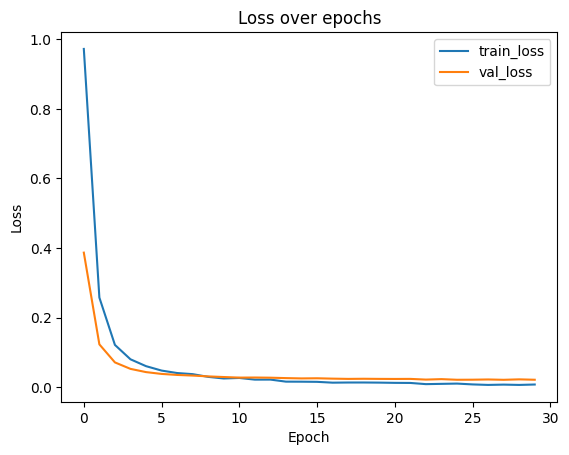

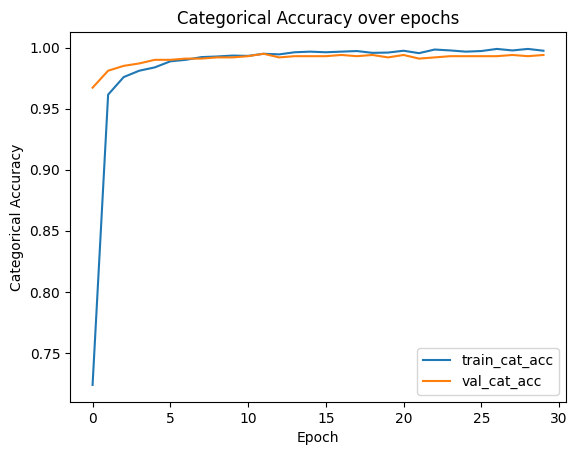

In [6]:

import matplotlib.pyplot as plt

# Plot: Loss
plt.figure()
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot: Categorical Accuracy
plt.figure()
plt.plot(history.history.get('categorical_accuracy', []), label='train_cat_acc')
plt.plot(history.history.get('val_categorical_accuracy', []), label='val_cat_acc')
plt.title('Categorical Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()


## 6. Evaluation: Detaillierte Leistungsanalyse auf Hold-out-Datensatz

**Was:**
- Umfassende Evaluation des besten Modells auf dem separaten EVAL-Datensatz
- Berechnung aller relevanten Klassifikationsmetriken und detaillierte Fehleranalyse

**Berechnete Metriken:**
- **Confusion Matrix** (Gesamt-Übersicht der Klassifikationsergebnisse)
- **Pro Klasse:** Precision, Recall (Sensitivity), Specificity, F1-Score, Accuracy
- **Fehlerraten:** Type I/II Error Rates
- **Aggregate Metriken:** Macro (ungewichtet) und Weighted (gewichtet) Averages

**Gespeicherte Artefakte:**
- `evaluation_summary_*.csv` — Vollständige Metrik-Tabelle
- `confusion_matrix_*.csv` — Raw Counts der Confusion Matrix
- `false_inferences_*.json` — Dateinamen aller FP/FN + Fehlklassifikationen (mit Vorhersage vs. wahre Klasse)

**Warum:**
- **Objektive Bewertung:** Hold-out-Set war nie in Training/Validation involviert
- **Detaillierte Analyse:** Pro-Klassen-Metriken decken klassenspezifische Schwächen auf
- **Fehleranalyse:** Identifikation problematischer Bilder für weitere Untersuchungen
- **Reproduzierbarkeit:** Alle Metriken und Fehler werden persistent gespeichert

**Visualisierungen:**
- **Confusion Matrix Heatmap** mit Zahlenwerten
- **F1-Score Balkendiagramm** pro Klasse
- **Klassenverteilung** des Evaluationsdatensatzes
- **False Positives vs. False Negatives** Vergleich pro Klasse

**Outputs:**
- CSV/JSON-Dateien mit allen Metriken und Fehlern
- Vier Visualisierungen zur Ergebnisinterpretation
- Konsolen-Summary mit Kernmetriken (Overall Accuracy, Macro F1, etc.)

Saved: outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/evaluation_summary_PT_MultiClassResNet50_Trackbed.csv
Saved: outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/confusion_matrix_PT_MultiClassResNet50_Trackbed.csv
Saved: outputs_trackbed/PT_MultiClassResNet50_Trackbed__20250907-153036/false_inferences_PT_MultiClassResNet50_Trackbed.json


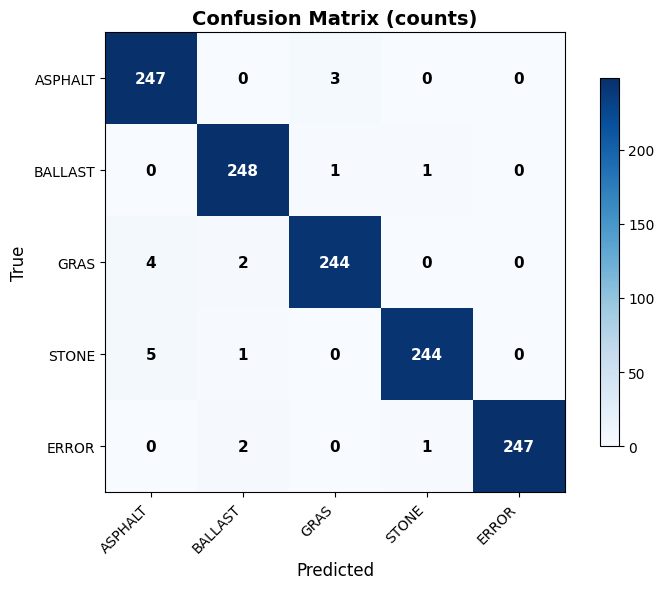

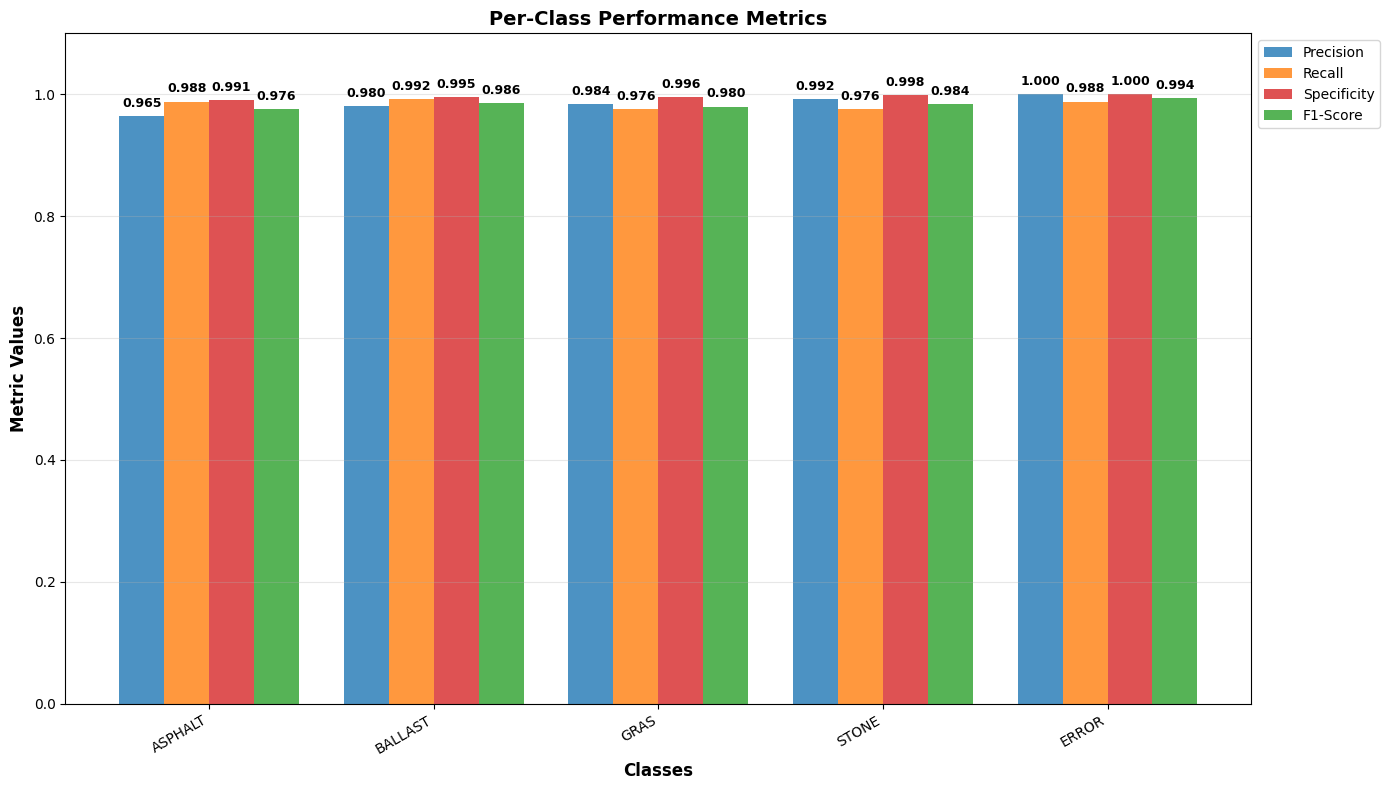

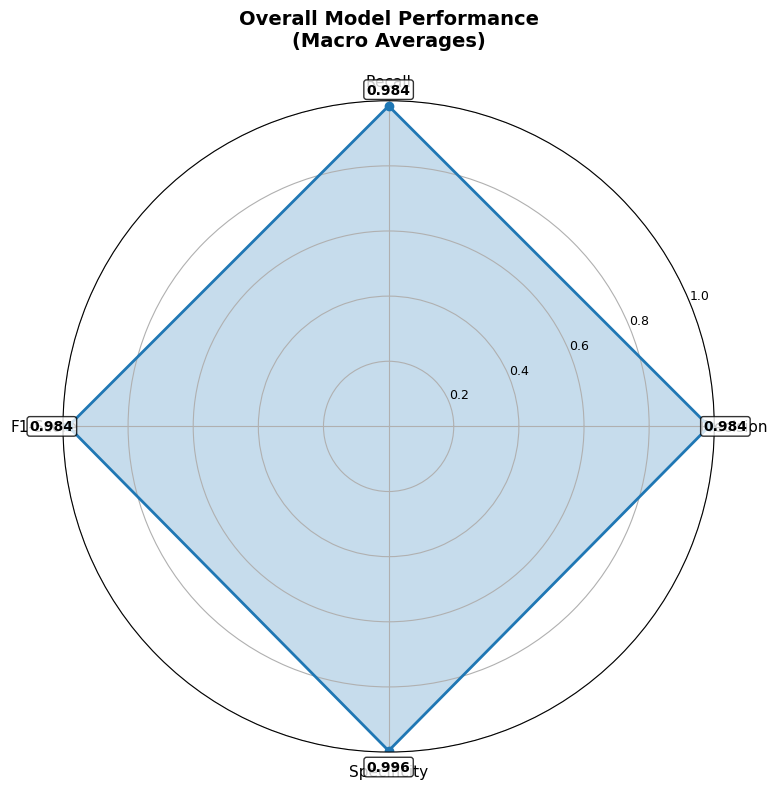

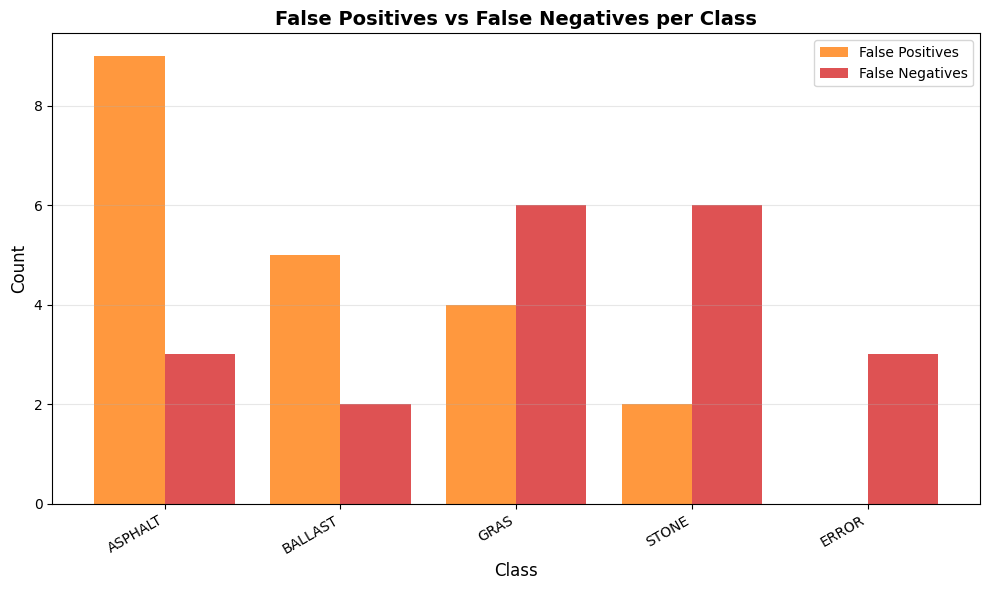


=== EVAL SUMMARY ===
Overall accuracy: 0.9840
Macro F1-Score:  0.9840
Total samples:    1250
Total misclass.:  20


In [7]:

from sklearn.metrics import confusion_matrix
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

# Ensure we load the best-saved model from disk (even if EarlyStopping restored in-memory weights)
best_model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Predict across the eval set
all_true_idx = []
all_pred_idx = []
false_dict = {
    'false_positive': {c: [] for c in CLASSES},
    'false_negative': {c: [] for c in CLASSES},
    'misclassified': []
}

for batch_imgs, batch_trues, batch_fns in eval_ds:
    probs = best_model.predict(batch_imgs, verbose=0)
    pred_idx = np.argmax(probs, axis=1)
    true_idx = np.argmax(batch_trues.numpy(), axis=1)

    all_pred_idx.extend(list(pred_idx))
    all_true_idx.extend(list(true_idx))

    # Track errors with filenames + confidence
    for ti, pi, fn, p in zip(true_idx, pred_idx, batch_fns.numpy(), probs):
        filename = fn.decode('utf-8') if isinstance(fn, (bytes, bytearray)) else str(fn)
        conf = float(np.max(p))
        if ti != pi:
            false_dict['misclassified'].append({
                'filename': filename,
                'true_class': CLASSES[int(ti)],
                'predicted_class': CLASSES[int(pi)],
                'confidence': conf
            })
        # Per-class FP/FN views
        for ci in range(NUM_CLASSES):
            # Binary view for class ci
            true_bin = (ti == ci)
            pred_bin = (pi == ci)
            if (not true_bin) and pred_bin:
                false_dict['false_positive'][CLASSES[ci]].append(f"{filename}_{conf:.3f}")
            if true_bin and (not pred_bin):
                false_dict['false_negative'][CLASSES[ci]].append(f"{filename}_{conf:.3f}")

all_true_idx = np.array(all_true_idx, dtype=int)
all_pred_idx = np.array(all_pred_idx, dtype=int)

# Overall confusion matrix (NUM_CLASSES x NUM_CLASSES)
overall_conf = confusion_matrix(all_true_idx, all_pred_idx, labels=list(range(NUM_CLASSES)))

# Build per-class binary TP/FP/FN/TN
binary_conf = np.zeros((NUM_CLASSES, 4), dtype=float)  # TP, FP, FN, TN
for ci in range(NUM_CLASSES):
    # For class ci: positive if true==ci / predicted==ci
    tp = np.sum((all_true_idx == ci) & (all_pred_idx == ci))
    fp = np.sum((all_true_idx != ci) & (all_pred_idx == ci))
    fn = np.sum((all_true_idx == ci) & (all_pred_idx != ci))
    tn = np.sum((all_true_idx != ci) & (all_pred_idx != ci))
    binary_conf[ci] = [tp, fp, fn, tn]

def _safe_div(a, b):
    return (a / b) if b != 0 else 0.0

# Compute metrics
tps, fps, fns, tns = binary_conf[:,0], binary_conf[:,1], binary_conf[:,2], binary_conf[:,3]
accuracies   = np.array([_safe_div(tp+tn, tp+fp+fn+tn) for tp,fp,fn,tn in binary_conf])
recalls      = np.array([_safe_div(tp, tp+fn) for tp,fn in zip(tps,fns)])              # aka sensitivity
specificity  = np.array([_safe_div(tn, tn+fp) for tn,fp in zip(tns,fps)])
typeI_err    = np.array([_safe_div(fp, fp+tn) for fp,tn in zip(fps,tns)])
typeII_err   = np.array([_safe_div(fn, tp+fn) for tp,fn in zip(tps,fns)])
precisions   = np.array([_safe_div(tp, tp+fp) for tp,fp in zip(tps,fps)])
f1_scores    = np.array([_safe_div(2*p*r, p+r) for p,r in zip(precisions,recalls)])

overall_acc  = _safe_div(np.trace(overall_conf), np.sum(overall_conf))

macro_precision = float(np.mean(precisions)) if len(precisions) else 0.0
macro_recall    = float(np.mean(recalls))    if len(recalls)    else 0.0
macro_f1        = float(np.mean(f1_scores))  if len(f1_scores)  else 0.0

supports = tps + fns
total    = np.sum(supports) if np.sum(supports) > 0 else 1.0

metrics = {
    "Accuracy": list(map(float, accuracies)) + [float(overall_acc)],
    "Precision": list(map(float, precisions)) + [float(macro_precision)],
    "Recall": list(map(float, recalls)) + [float(macro_recall)],
    "Specificity": list(map(float, specificity)) + [float(np.mean(specificity) if len(specificity) else 0.0)],
    "F1-Score": list(map(float, f1_scores)) + [float(macro_f1)],
    "Type I Error": list(map(float, typeI_err)) + [float(np.mean(typeI_err) if len(typeI_err) else 0.0)],
    "Type II Error": list(map(float, typeII_err)) + [float(np.mean(typeII_err) if len(typeII_err) else 0.0)]
}

# Save CSV metrics and confusion matrix + false inferences JSON
eval_csv = str(Path(run_dir) / f"evaluation_summary_{MODEL_NAME}.csv")
conf_csv = str(Path(run_dir) / f"confusion_matrix_{MODEL_NAME}.csv")
false_json = str(Path(run_dir) / f"false_inferences_{MODEL_NAME}.json")

with open(eval_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Metric", "Class", "Value"])
    # per-class
    for name, vals in metrics.items():
        if name.startswith("Weighted"):
            continue
        for idx, v in enumerate(vals[:-1]):
            writer.writerow([name, CLASSES[idx], v])
    # macro/overall
    writer.writerow([])
    writer.writerow(["Metric", "Overall/Average", "Value"])
    for name, vals in metrics.items():
        if name.startswith("Weighted"):
            writer.writerow([name, "Weighted", vals[0]])
        else:
            writer.writerow([name, "Macro Average", vals[-1]])

np.savetxt(conf_csv, overall_conf, delimiter=',', fmt='%d', header=','.join(CLASSES), comments='')

with open(false_json, 'w') as jf:
    json.dump(false_dict, jf, indent=2)

print("Saved:", eval_csv)
print("Saved:", conf_csv)
print("Saved:", false_json)

# --- Visualizations -----------------------------------------------------------

# (1) Confusion matrix heatmap with better color scheme
plt.figure(figsize=(8, 6))
im = plt.imshow(overall_conf, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix (counts)', fontsize=14, fontweight='bold')
plt.xticks(ticks=range(NUM_CLASSES), labels=CLASSES, rotation=45, ha='right')
plt.yticks(ticks=range(NUM_CLASSES), labels=CLASSES)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

# Add text annotations with good contrast
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        text_color = 'white' if overall_conf[i, j] > overall_conf.max() / 2 else 'black'
        plt.text(j, i, str(overall_conf[i, j]), ha='center', va='center', 
                color=text_color, fontsize=11, fontweight='bold')

plt.colorbar(im, shrink=0.8)
plt.tight_layout()
plt.show()

# (2) Comprehensive Metrics Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for visualization
metric_names = ['Precision', 'Recall', 'Specificity', 'F1-Score']
x = np.arange(len(CLASSES))
width = 0.2

colors = ['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c']

for i, metric in enumerate(metric_names):
    values = metrics[metric][:-1]  # Exclude macro average
    bars = ax.bar(x + i*width, values, width, label=metric, color=colors[i], alpha=0.8)
    
    # Add value labels on top of bars
    for j, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Metric Values', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(CLASSES, rotation=30, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# (3) Alternative Suggestion: Radar Chart for Macro Metrics
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

# Macro metrics for radar chart
radar_metrics = ['Precision', 'Recall', 'F1-Score', 'Specificity']
radar_values = [metrics[m][-1] for m in radar_metrics]  # Get macro averages

# Number of variables
N = len(radar_metrics)

# Compute angle for each axis
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Add values
radar_values += radar_values[:1]  # Complete the circle

# Plot
ax.plot(angles, radar_values, 'o-', linewidth=2, label='Macro Average', color='#1f77b4')
ax.fill(angles, radar_values, alpha=0.25, color='#1f77b4')

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
ax.grid(True)

# Add value labels
for angle, value, metric in zip(angles[:-1], radar_values[:-1], radar_metrics):
    ax.text(angle, value + 0.05, f'{value:.3f}', ha='center', va='center', 
            fontsize=10, fontweight='bold', 
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

ax.set_title('Overall Model Performance\n(Macro Averages)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# (4) False Positives vs False Negatives per class
fp_counts = [len(false_dict['false_positive'][c]) for c in CLASSES]
fn_counts = [len(false_dict['false_negative'][c]) for c in CLASSES]

plt.figure(figsize=(10, 6))
x = np.arange(NUM_CLASSES)
plt.bar(x - 0.2, fp_counts, width=0.4, label='False Positives', color='#ff7f0e', alpha=0.8)
plt.bar(x + 0.2, fn_counts, width=0.4, label='False Negatives', color='#d62728', alpha=0.8)
plt.xticks(x, CLASSES, rotation=30, ha='right')
plt.title('False Positives vs False Negatives per Class', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n=== EVAL SUMMARY ===")
print(f"Overall accuracy: {overall_acc:.4f}")
print(f"Macro F1-Score:  {macro_f1:.4f}")
print(f"Total samples:    {int(np.sum(overall_conf))}")
print(f"Total misclass.:  {len(false_dict['misclassified'])}")


## 7. Qualitative Stichprobe: Vorhersage-Visualisierung

**Was:**
- Visualisierung einiger Vorhersagen mit wahren Labels und Konfidenzwerten
- Direkte Anzeige aus `eval_ds` Tensoren (nicht von Festplatte)

**Warum:**
- **Qualitative Kontrolle:** Visueller Eindruck der Modell-Performance auf echten Bildern
- **Fehlerverständnis:** Erkennung von Mustern bei Fehlklassifikationen
- **Konfidenz-Analyse:** Bewertung der Modell-Sicherheit bei verschiedenen Vorhersagen

**Interpretation:**
- **Korrekte Vorhersagen:** Hohe Konfidenz bei richtigen Klassifikationen ist wünschenswert
- **Fehlklassifikationen:** Niedrige Konfidenz kann auf schwierige/mehrdeutige Bilder hinweisen
- **Systematische Fehler:** Wiederholte Verwechslungen zwischen bestimmten Klassen

**Outputs:**
- Grid-Anzeige mit 6 Beispielbildern
- Je Bild: Vorhersage, Konfidenz, wahre Klasse

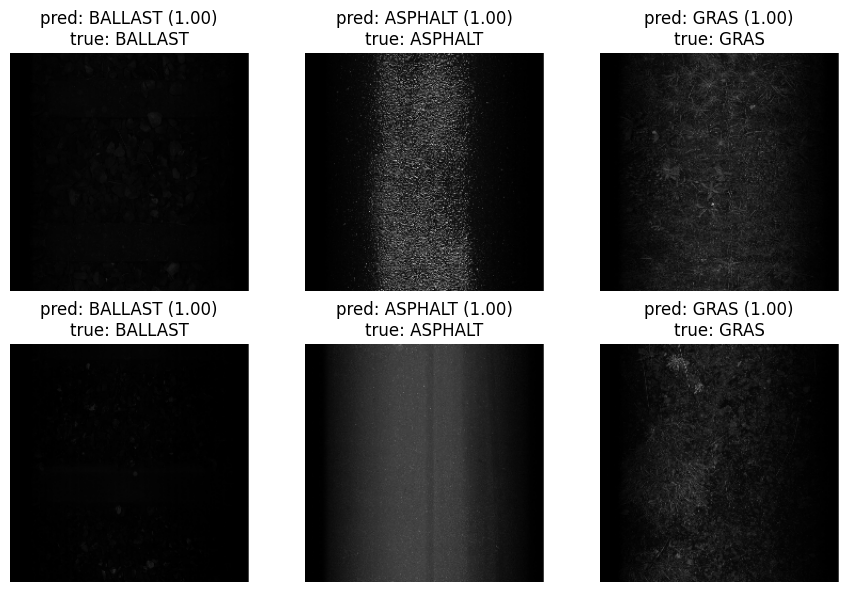

In [8]:

import matplotlib.pyplot as plt

def show_eval_samples(ds, model, k=6):
    imgs_shown = 0
    for imgs, labels, fns in ds:
        probs = model.predict(imgs, verbose=0)
        pred_idx = np.argmax(probs, axis=1)
        true_idx = np.argmax(labels.numpy(), axis=1)

        b = imgs.shape[0]
        rows = int(math.ceil(min(k, b) / 3))
        cols = 3 if k >= 3 else min(k, b)

        plt.figure(figsize=(cols*3, rows*3))
        for i in range(min(k, b)):
            ax = plt.subplot(rows, cols, i+1)
            ax.imshow(imgs[i].numpy())
            pidx = int(pred_idx[i])
            tidx = int(true_idx[i])
            conf = float(np.max(probs[i]))
            ax.set_title(f"pred: {CLASSES[pidx]} ({conf:.2f})\ntrue: {CLASSES[tidx]}")
            ax.axis('off')
        plt.tight_layout()
        plt.show()

        imgs_shown += min(k, b)
        if imgs_shown >= k:
            break

# Uncomment to preview a few eval samples (set k as needed)
show_eval_samples(eval_ds, best_model, k=6)


## 8. Dokumentation & Reproduzierbarkeit

**Ergebnis:**
Dieses Notebook liefert ein vollständig trainiertes und evaluiertes CNN-Modell für die Schienenuntergrund-Klassifikation mit umfassender Dokumentation aller Parameter, Metriken und Ergebnisse. Die systematische Herangehensweise und detaillierte Evaluation bilden eine solide Grundlage für den praktischen Einsatz in der Gleisbett-Analyse.

**Gespeicherte Artefakte:**
- **Hyperparameter** und **Klassennamen** werden neben dem trainierten Modell im Run-Ordner gespeichert
- **Bestes Modell** (nach `val_loss`) wird im Keras-Format gespeichert: `<OUTPUT_DIR>/<MODEL_NAME>__<timestamp>/<MODEL_NAME>.keras`
- **Metriken und Confusion Matrix** sind als CSV-Dateien verfügbar
- **Fehlklassifikationen** werden als JSON gespeichert (mit Dateinamen und Konfidenzwerten)

**Nächste Schritte (optional):**
- **Fine-Tuning:** Einfrieren der oberen ResNet-Schichten aufheben (mit kleiner Learning Rate)
- **Klassenbalancierung:** Class-balanced Sampling / Focal Loss bei unbalancierten Datensätzen
- **Cross-Validation:** Integration verschiedener TFRecord-Shards (falls verfügbar)